In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ML Models
# ML Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split


from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Attention
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Time Series Split
from sklearn.model_selection import TimeSeriesSplit


### Technnincal indicators

In [48]:

def compute_rsi(series, period=14):
    delta = series.diff()
    gains = delta.where(delta > 0, 0.0)
    losses = -delta.where(delta < 0, 0.0)
    avg_gain = gains.rolling(window=period).mean()
    avg_loss = losses.rolling(window=period).mean()
    rs = avg_gain / (avg_loss + 1e-9)
    return 100.0 - (100.0 / (1.0 + rs))

def compute_macd(series, fastperiod=12, slowperiod=26, signalperiod=9):
    ema_fast = series.ewm(span=fastperiod, adjust=False).mean()
    ema_slow = series.ewm(span=slowperiod, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signalperiod, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return macd_line, signal_line, macd_hist

def compute_ma(series, window=20):
    return series.rolling(window=window).mean()


In [49]:

csv_file = "merged_news_stock_data.csv"
df = pd.read_csv(csv_file, parse_dates=["Date"])
df.sort_values("Date", inplace=True)
df.dropna(subset=["Date"], inplace=True)
df.reset_index(drop=True, inplace=True)


In [50]:

df["RSI"] = compute_rsi(df["Close_Price"])
df["MACD_line"], df["MACD_signal"], df["MACD_hist"] = compute_macd(df["Close_Price"])
df["MA20"] = compute_ma(df["Close_Price"])
df.dropna(inplace=True)
df["Close_next"] = df["Close_Price"].shift(-1)
df.dropna(inplace=True)


### Feature Selection

In [51]:

# Define the improved LSTM model code
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping



# Selecting features and target variable
features = ["RSI", "MACD_line", "MACD_signal", "MACD_hist", "MA20",
            "sentiment_polarity", "sentiment_neg", "sentiment_neu", "sentiment_pos"]
target = "Close_next"

# Handling missing values by interpolation
df.fillna(method='ffill', inplace=True)


## LSTM

In [52]:

# Scaling the data using RobustScaler (better for outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df[features])
y_scaled = scaler.fit_transform(df[[target]])

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# Reshaping input data for LSTM (samples, time steps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Building the improved LSTM model
lstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(1, X_train.shape[1])),
    Dropout(0.4),
    LSTM(64, return_sequences=True),
    Dropout(0.4),
    LSTM(32, return_sequences=False),
    Dropout(0.4),
    Dense(16, activation="relu"),
    Dense(1)
])

# Compiling the model with a lower learning rate and AdamW optimizer
lstm_model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0005), loss="mse")

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Training the model
lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping])

# Making predictions
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Evaluating performance
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
lstm_r2 = r2_score(y_test, y_pred_lstm)


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.7561
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0764
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0478
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0415
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0356
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0333
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0278
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0298
Epoch 9/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0268
Epoch 10/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0295
Epoch 11/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0245
Epoch 12/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0278
Epoch 13/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0245
Epoch 14/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0256
Epoch 15/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1

In [53]:

print(f"Improved LSTM Model - RMSE: {lstm_rmse:.4f}, R²: {lstm_r2:.4f}")


Improved LSTM Model - RMSE: 0.0591, R²: 0.9745


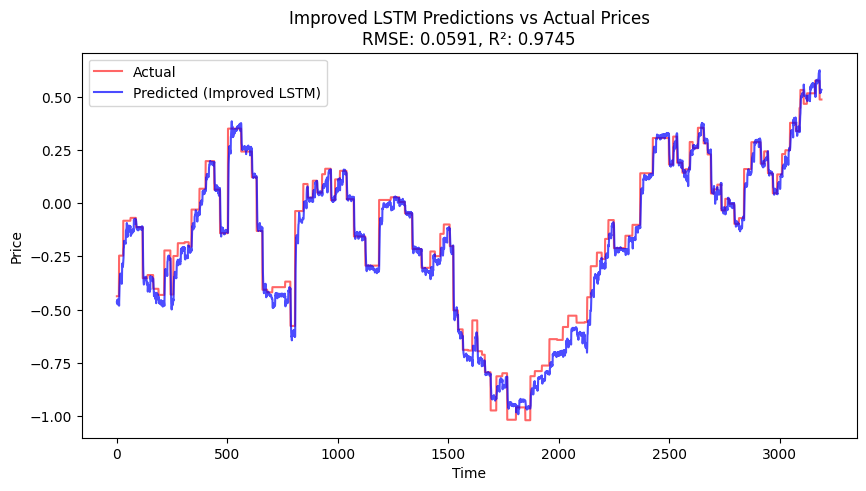

In [54]:
# Plot Actual vs Predicted Prices for Improved LSTM Model
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual", color="red", alpha=0.6)
plt.plot(y_pred_lstm, label="Predicted (Improved LSTM)", color="blue", alpha=0.7)
plt.title(f"Improved LSTM Predictions vs Actual Prices\nRMSE: {lstm_rmse:.4f}, R²: {lstm_r2:.4f}")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [55]:

# # Splitting into Train, Validation, and Test Sets (70%-15%-15%)
# X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, shuffle=False)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# # Reshaping input data for LSTM
# X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_val_lstm = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
# X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# # Rebuilding the LSTM Model for Training with Validation Split
# lstm_model = Sequential([
#     Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)), input_shape=(1, X_train.shape[1])),
#     Dropout(0.4),
#     LSTM(64, return_sequences=True),
#     Dropout(0.4),
#     LSTM(32, return_sequences=False),
#     Dropout(0.4),
#     Dense(16, activation="relu"),
#     Dense(1)
# ])

# # Compiling with AdamW optimizer and lower learning rate
# lstm_model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0005), loss="mse")

# # Training with validation set
# history = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=64, validation_data=(X_val_lstm, y_val), verbose=1)





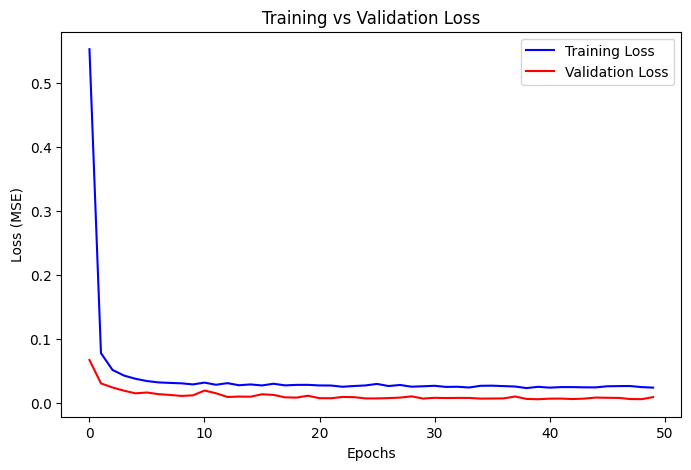

In [56]:

# Plot Training vs. Validation Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

In [57]:
# # Train and Test Predictions
# y_train_pred = lstm_model.predict(X_train_lstm).flatten()
# y_test_pred = lstm_model.predict(X_test_lstm).flatten()

# # Compute R² Scores
# train_r2 = r2_score(y_train, y_train_pred)
# test_r2 = r2_score(y_test, y_test_pred)

train_r2, test_r2

(0.9897981455342107, 0.9729907371252335)

## Random Forest

In [ ]:
# Updated Random Forest Parameters for Further Optimization
rf_optimized_params = {
    'n_estimators': 200,  # Increased number of trees
    'max_depth': 20,  # Reduced max depth
    'min_samples_split': 10,
    'max_features': 'sqrt',
    'random_state': 42
}


# Instantiate Models
rf_optimized = RandomForestRegressor(**rf_optimized_params)

# Train Models
rf_optimized.fit(X_train, y_train)

# Make Predictions
rf_optimized_pred = rf_optimized.predict(X_test)

# Evaluate Performance
rf_optimized_rmse = mean_squared_error(y_test, rf_optimized_pred, squared=False)
rf_optimized_r2 = r2_score(y_test, rf_optimized_pred)


# Return Results
rf_optimized_rmse, rf_optimized_r2

(0.06392161733460999, 0.970095388019896)

In [59]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


## Light GBM

In [60]:
# Optimized Model Parameters
best_lgbm = LGBMRegressor(num_leaves=40, n_estimators=500, max_depth=3, learning_rate=0.1, random_state=42)

# Fit models on training data
best_lgbm.fit(X_train, y_train)

# Predictions
lgbm_pred = best_lgbm.predict(X_test)

# Evaluate Performance
lgbm_rmse = mean_squared_error(y_test, lgbm_pred, squared=False)
lgbm_r2 = r2_score(y_test, lgbm_pred)




# Print Results
print(f"Optimized LightGBM - RMSE: {lgbm_rmse:.4f}, R²: {lgbm_r2:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2231
[LightGBM] [Info] Number of data points in the train set: 12758, number of used features: 9
[LightGBM] [Info] Start training from score 0.027931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [61]:

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2, y_pred


### XGBoost

In [62]:
# Optimized Model Parameters
best_xgb = XGBRegressor(subsample=1.0, n_estimators=500, max_depth=3, learning_rate=0.1, random_state=42)

# Fit models on training data
best_xgb.fit(X_train, y_train)

# Predictions
xgb_pred = best_xgb.predict(X_test)



xgb_rmse = mean_squared_error(y_test, xgb_pred, squared=False)
xgb_r2 = r2_score(y_test, xgb_pred)


# Print Results
print(f"Optimized XGBoost - RMSE: {xgb_rmse:.4f}, R²: {xgb_r2:.4f}")


Optimized XGBoost - RMSE: 0.0346, R²: 0.9912


In [71]:

ts_split = TimeSeriesSplit(n_splits=5)
feature_cols = ["RSI", "MACD_line", "MACD_signal", "MACD_hist", "MA20", "sentiment_polarity", "sentiment_neg", "sentiment_neu", "sentiment_pos"]
X = df[feature_cols]
y = df["Close_next"]
train_index, test_index = list(ts_split.split(X))[-1]
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [72]:

# Linear Regression
lr_model = LinearRegression()
lr_rmse, lr_r2, lr_pred = evaluate_model(lr_model, X_train, X_test, y_train, y_test)




In [73]:
# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb_rmse, gb_r2, gb_pred = evaluate_model(gb_model, X_train, X_test, y_train, y_test)


In [74]:
# SVR
svr_model = SVR(kernel='rbf')
svr_rmse, svr_r2, svr_pred = evaluate_model(svr_model, X_train, X_test, y_train, y_test)


In [75]:

# Results Dictionary
results = {
    "LinearRegression": (lr_rmse, lr_r2, lr_pred),
    "RandomForest": (rf_optimized_rmse, rf_optimized_r2, rf_optimized_pred),
    "XGBoost": (xgb_rmse, xgb_r2, xgb_pred),
    "LightGBM": (lgbm_rmse, lgbm_r2, lgbm_pred),
    "GradientBoosting": (gb_rmse, gb_r2, gb_pred),
    "SVR": (svr_rmse, svr_r2, svr_pred),
    "LSTM": (lstm_rmse, lstm_r2, y_pred_lstm)
}

LinearRegression: RMSE = 0.6655, R² = 0.9941


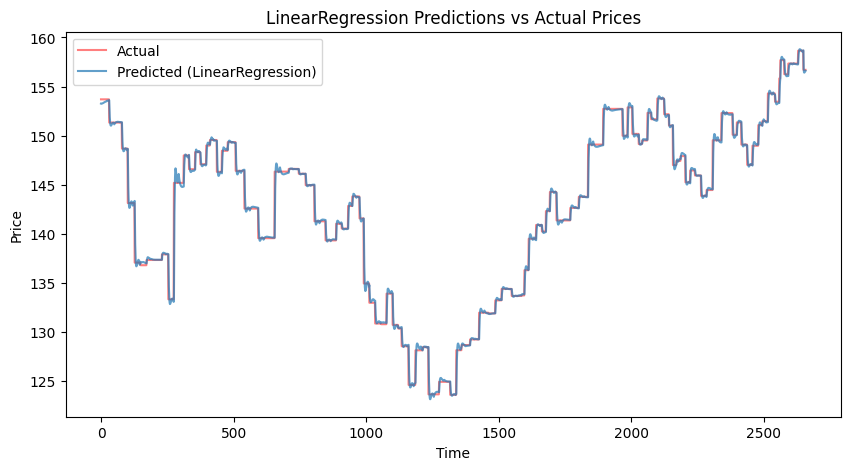

RandomForest: RMSE = 0.0639, R² = 0.9701


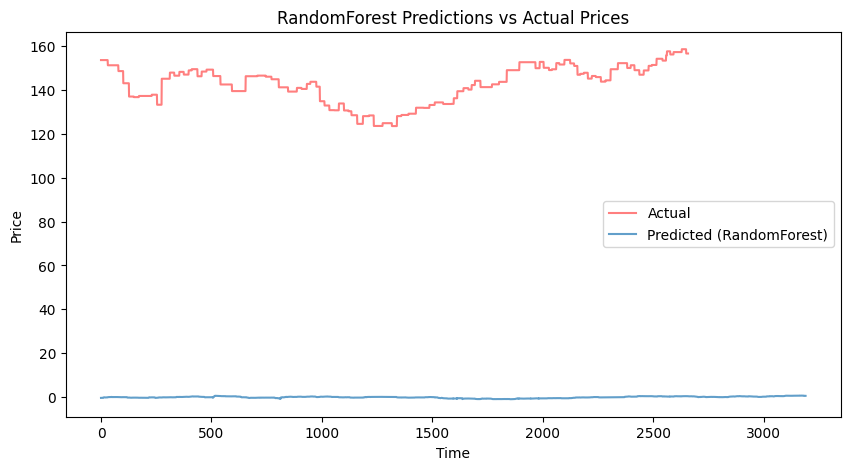

XGBoost: RMSE = 0.0346, R² = 0.9912


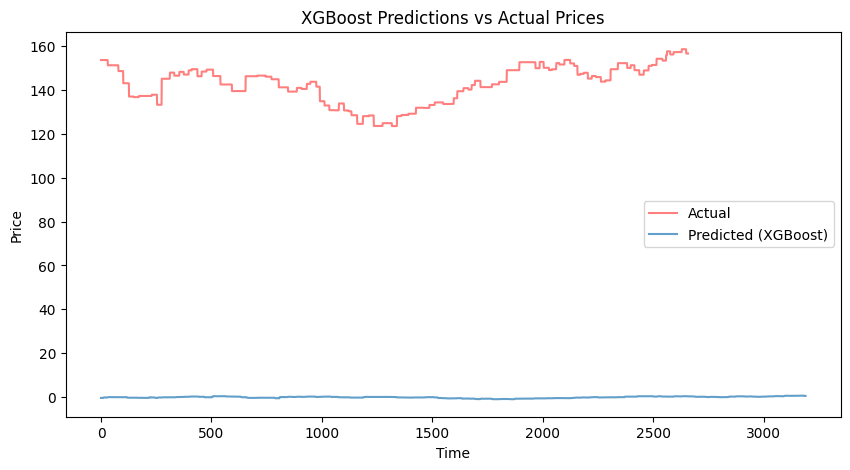

LightGBM: RMSE = 0.0342, R² = 0.9914


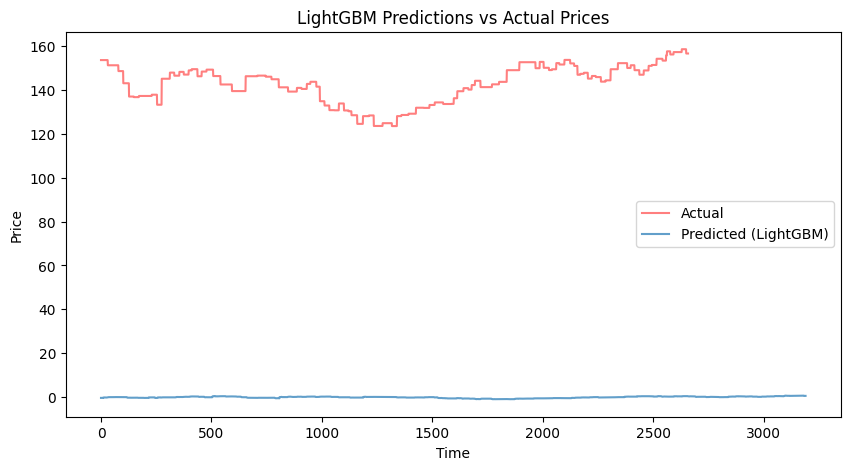

GradientBoosting: RMSE = 0.7563, R² = 0.9924


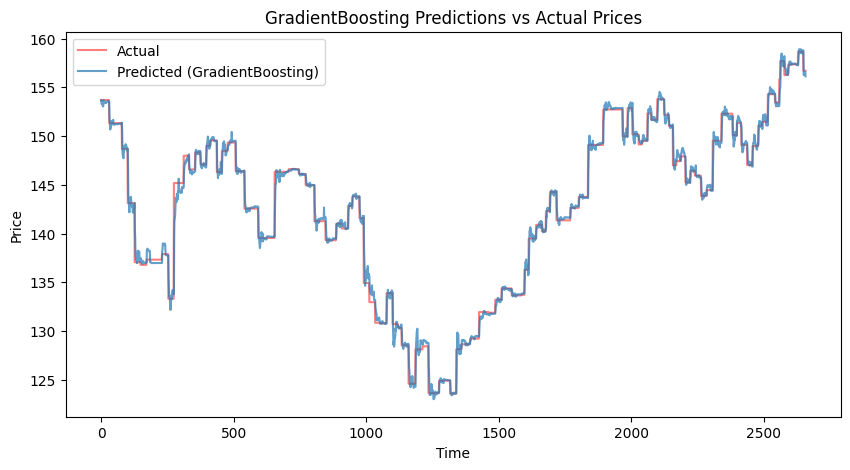

SVR: RMSE = 1.1837, R² = 0.9813


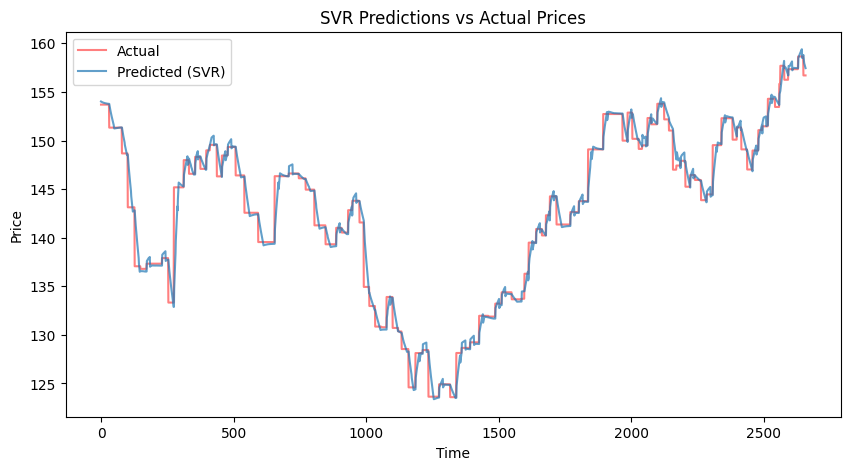

LSTM: RMSE = 0.0591, R² = 0.9745


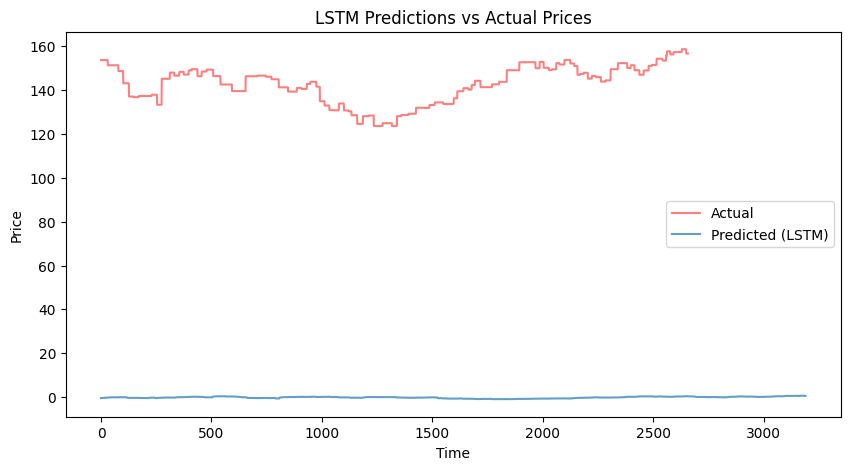

In [76]:


for model, (rmse, r2, y_pred) in results.items():
    print(f"{model}: RMSE = {rmse:.4f}, R² = {r2:.4f}")
    plt.figure(figsize=(10,5))
    plt.plot(y_test.values, label='Actual', color='red', alpha=0.5)
    plt.plot(y_pred, label=f'Predicted ({model})', alpha=0.7)
    plt.title(f"{model} Predictions vs Actual Prices")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
